VI.9.32
According to the census , the US population changed as follows
|Year|Population(people)|
|---|---|
|1910|92 228 496|
|1920|106 021 537|
|1930|123 202 624|
|1940|132 164 569|
|1950|151 325 798|
|1960|179 323 175|
|1970|203 211 926|
|1980|226 545 805|
|1990|248 709 873|
|2000|281 421 906|

According to the data given, construct an interpolant in the form of Newton. Calculate the extrapolated population value
In 2010 and compare with the exact value of 308,745,538 people.

In [1]:
import numpy as np
import bisect

years = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
population = np.array([92228496,
                       106021537,
                       123202624,
                       132164569,
                       151325798,
                       179323175,
                       203211926,
                       226545805,
                       248709873,
                       281421906])

In [2]:
#table of separated differences
def column(x, y):
  size = np.shape(x)[0]
  sp_tbl = np.zeros([size, size])
  for i in range (0, size):
    sp_tbl[i, 0] = population[i]
  for j in range (1, size):
    for i in range (1, size):
      sp_tbl[i, j] = (sp_tbl[i, j - 1] - sp_tbl[i-1, j-1]) / (years[i] - years[i - j])
  
  res = np.zeros([size])
  for i in range(0, size):
    res[i] = sp_tbl[i, i]
  
  return res
coefficients = column(years, population)
print(coefficients)

[ 9.22284960e+07  1.37930410e+06  1.69402300e+04 -1.93453133e+03
  1.25106725e+02 -4.15059800e+00  8.05654167e-02 -7.56485278e-04
 -7.56467535e-06  5.09932804e-07]


Newton 's polynomial:

$N_n(x) = b_0 + b_1(x-x_0) + b_2(x-x_0)(x-x_1) + b_n(x - x_0)(x-x_1)...(x-x_n)$

In [10]:
def polynomial(coeffs, x_column, x0):
    sum = coeffs[0]
    xs_multiply = 1.0
    for i in range(np.shape(coeffs)[0] - 1):
        xs_multiply = xs_multiply * (x0 - x_column[i])
        sum = sum + coeffs[i + 1] * xs_multiply
    return sum

print ("Interpolated value = %.0f" % (polynomial(coefficients, years, 2010)))
print ("Expected value = ", 308745538)

Interpolated value = 827906509
Expected value =  308745538


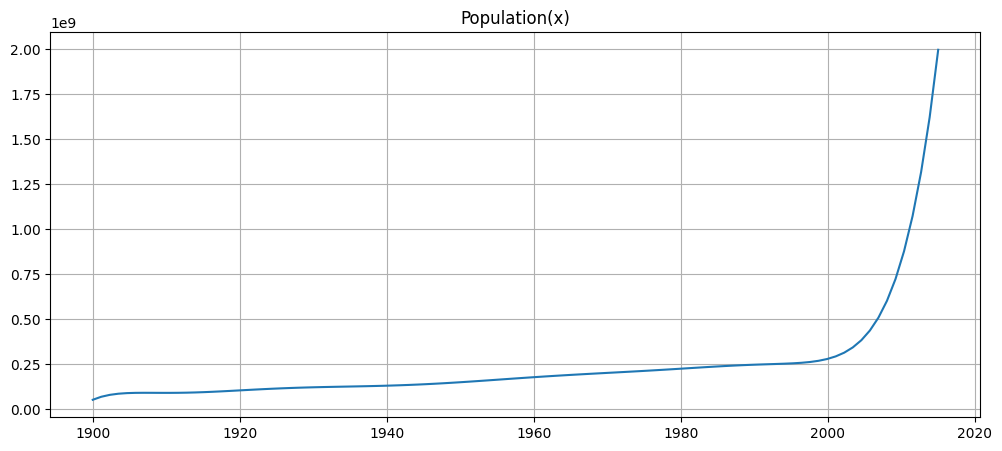

In [9]:
import matplotlib.pyplot as plt

def func_of_x(i):
    return polynomial(coefficients, years, i)
x = np.linspace(start = 1900, stop = 2015, num = 100)
y = list(map(lambda i: func_of_x(i), x))
plt.figure(figsize=[12, 5], dpi=100)
plt.plot(x, y)
plt.title("Population(x)")
plt.grid()

Using the same data to build a spline approximation, extrapolate the data for 2010, compare with the exact value

In [4]:
def diffs(x):
  sz = len(x) - 1
  res = np.zeros(sz)
  for i in range (sz):
    res[i] = x[i+1] - x[i]

  return res

def calc_tridiag(A, B, C, D):
  c_p = np.append(C, 0)
  d_p = np.zeros(np.shape(B)[0])
  res = np.zeros(np.shape(B)[0])
  for i in range(0, np.shape(B)[0]):
    if i == 0:
      c_p[i] = C[i] / B[i]
      d_p[i] = D[i] / B[i]
    else:
      c_p[i] = c_p[i] / (B[i] - c_p[i - 1] * A[i - 1])
      d_p[i] = (D[i] - d_p[i - 1] * A[i - 1]) / (B[i] - c_p[i - 1] * A[i - 1])

  res[-1] = d_p[-1]
  for i in range(np.shape(B)[0] - 2, -1, -1):
      res[i] = d_p[i] - c_p[i] * res[i + 1]

  return res

def spline(x, y, num):
  n = len(x)
  h = diffs(x)
  A = np.zeros(n - 1)
  C = np.zeros(n - 1)
  for i in range (n - 2):
    A[i] = h[i] / (h[i] + h[i + 1])
    C[i + 1] = h[i] / (h[i] + h[i + 1])
  B = np.zeros(n)
  for i in range (n):
    B[i] = 2
  D = np.zeros(n)
  for i in range (1, n-1):
    D[i] = 6 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1]) / (h[i] + h[i-1])

  tridiag_solved = calc_tridiag(A, B, C, D)

  cfs = np.array([
      [(tridiag_solved[i+1]-tridiag_solved[i]) * h[i] * h[i] / 6, tridiag_solved[i] * h[i] * h[i] / 2,
           (y[i + 1] - y[i] - (tridiag_solved[i + 1]+  2 * tridiag_solved[i]) * h[i] * h[i] / 6), y[i]]
              for i in range(n - 1)
  ])

  idx = min(bisect.bisect(x, num)-1, n-2)
  z = (num - x[idx]) / h[idx]
  C = cfs[idx]

  return (((C[0] * z) + C[1]) * z + C[2]) * z + C[3]



In [5]:
print ("Splined value = %.0f" % (spline(years, population, 2010)))
print ("Expected value = ", 308745538)

Splined value = 314133939
Expected value =  308745538


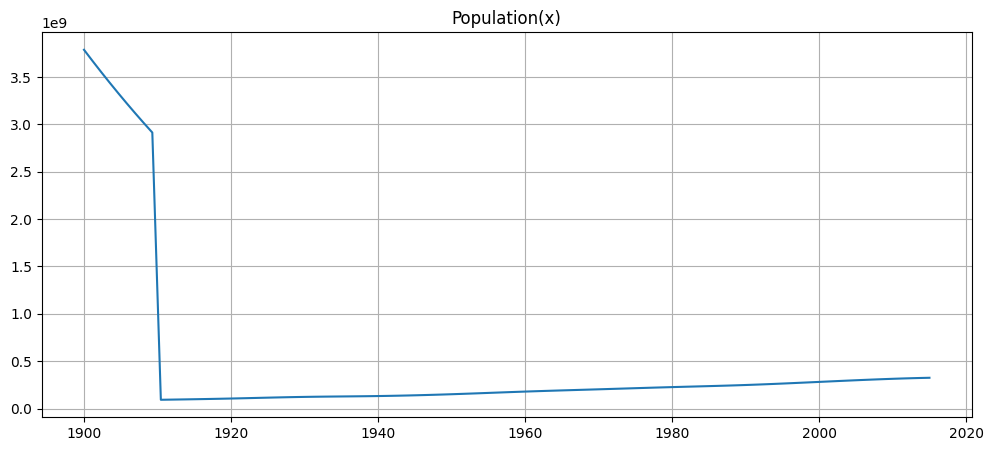

In [11]:
def func_of_x(i):
    return spline(years, population, i)
x = np.linspace(start = 1900, stop = 2015, num = 100)
y = list(map(lambda i: func_of_x(i), x))
plt.figure(figsize=[12, 5], dpi=100)
plt.plot(x, y)
plt.title("Population(x)")
plt.grid()

Results getted via spline is much more precisely